In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile

from qiskit_aer import QasmSimulator
# from qiskit_aer.noise import NoiseModel, pauli_error

from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import Aer, execute

from scipy.optimize import OptimizeResult

In [1]:

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print('eps', eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion
    # backend = QasmSimulator(method='statevector', noise_model=noise_model)
    backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots



    # job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    transpiled_circuit = transpile(circ, backend)
    # job = backend.run(transpiled_circuit, shots=shots1)
    job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    transpiled_circuit = transpile(circ_2, backend)
    # job = backend.run(transpiled_circuit, shots=shots2)
    job = execute(circ_2, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    transpiled_circuit = transpile(circ_3, backend)
    # job = backend.run(transpiled_circuit, shots=shots2)
    job = execute(circ_3, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])
    print("Len: ", len(history.energies))

    return E


theta_test = [-2]
shots = 600

record_history = history()
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(args.shots, args.trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.37429500579999997
Len:  1
theta track:  [-1]
energy track:  -0.5712240058
Len:  2
eps 0.02
theta track:  [-1.9]
energy track:  -0.3701530057999999
Len:  3
theta track:  [-1.88]
energy track:  -0.38863400580000007
Len:  4
eps 0.02
theta track:  [-1.82574163]
energy track:  -0.3724890058
Len:  5
theta track:  [-1.80574163]
energy track:  -0.4075540058
Len:  6
eps 0.02
theta track:  [-1.75722733]
energy track:  -0.38373000579999994
Len:  7
theta track:  [-1.73722733]
energy track:  -0.3848400058000001
Len:  8
eps 0.02
theta track:  [-1.70075792]
energy track:  -0.40086900579999996
Len:  9
theta track:  [-1.68075792]
energy track:  -0.4001980057999999
Len:  10
eps 0.02
theta track:  [-1.65323095]
energy track:  -0.4067670058
Len:  11
theta track:  [-1.63323095]
energy track:  -0.41567200579999997
Len:  12
eps 0.02
theta track:  [-1.60979527]
energy track:  -0.41978900579999995
Len:  13
theta track:  [-1.58979527]
energy track:  -0.4340370058
Len:  14
ep

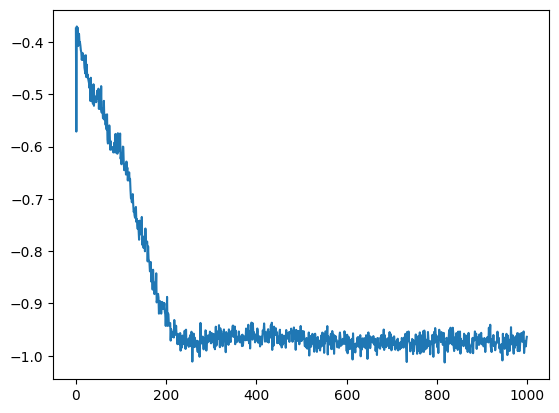

In [2]:
plt.plot(record_history.energies)

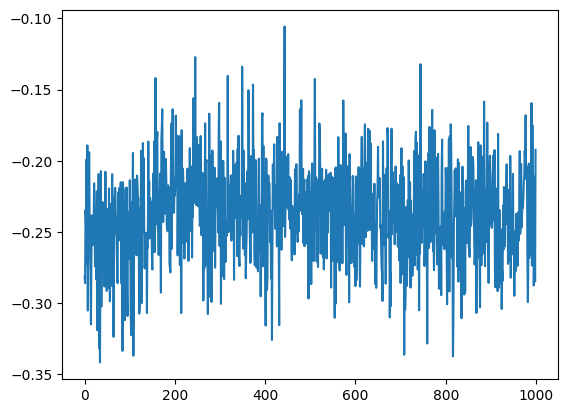

In [7]:
plt.plot(record_history.energies)

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile

from qiskit_aer import QasmSimulator
# from qiskit_aer.noise import NoiseModel, pauli_error

from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import Aer, execute

from scipy.optimize import OptimizeResult

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print('eps', eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion
    backend = QasmSimulator(method='statevector', noise_model=noise_model)
    # backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots



    # job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    transpiled_circuit = transpile(circ, backend)
    # job = backend.run(transpiled_circuit, shots=shots1)
    job = execute(circ, backend, shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    transpiled_circuit = transpile(circ_2, backend)
    # job = backend.run(transpiled_circuit, shots=shots2)
    job = execute(circ_2, backend, shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    transpiled_circuit = transpile(circ_3, backend)
    # job = backend.run(transpiled_circuit, shots=shots2)
    job = execute(circ_3, backend, shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])
    print("Len: ", len(history.energies))

    return E


theta_test = [-2]
shots = 600

record_history = history()
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(args.shots, args.trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.24180000579999997
Len:  1
theta track:  [-1]
energy track:  -0.28829600580000003
Len:  2
eps 0.02
theta track:  [-1.9]
energy track:  -0.2164870058
Len:  3
theta track:  [-1.88]
energy track:  -0.29436400579999994
Len:  4
eps 0.02
theta track:  [-1.80319926]
energy track:  -0.2282320058
Len:  5
theta track:  [-1.78319926]
energy track:  -0.20563600580000002
Len:  6
eps 0.02
theta track:  [-1.74672392]
energy track:  -0.1493550058
Len:  7
theta track:  [-1.72672392]
energy track:  -0.1922540058
Len:  8
eps 0.02
theta track:  [-1.68000892]
energy track:  -0.27167600580000006
Len:  9
theta track:  [-1.66000892]
energy track:  -0.2370660058
Len:  10
eps 0.02
theta track:  [-1.64457542]
energy track:  -0.2690250058
Len:  11
theta track:  [-1.62457542]
energy track:  -0.21680200579999998
Len:  12
eps 0.02
theta track:  [-1.64031725]
energy track:  -0.21413200580000002
Len:  13
theta track:  [-1.62031725]
energy track:  -0.2168220058
Len:  14
eps 0.02
thet

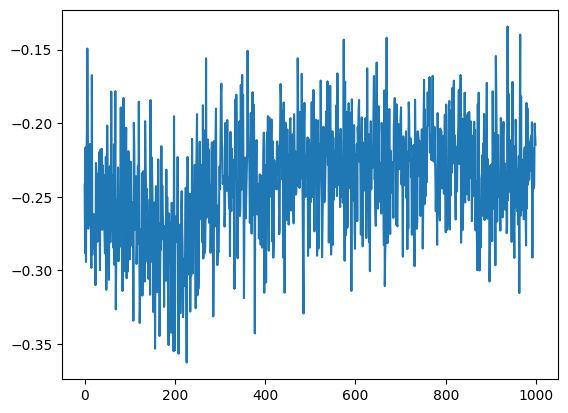

In [5]:
plt.plot(record_history.energies)

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile

from qiskit_aer import QasmSimulator
# from qiskit_aer.noise import NoiseModel, pauli_error

from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import Aer, execute

from scipy.optimize import OptimizeResult

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print('eps', eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion
    # backend = QasmSimulator(method='statevector', noise_model=noise_model)
    backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots



    # job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    transpiled_circuit = transpile(circ, backend)
    job = backend.run(circ, shots=shots1)
    # job = execute(circ, backend, shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    # transpiled_circuit = transpile(circ_2, backend)
    job = backend.run(circ_2, shots=shots2)
    # job = execute(circ_2, backend, shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    transpiled_circuit = transpile(circ_3, backend)
    job = backend.run(circ_3, shots=shots2)
    # job = execute(circ_3, backend, shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])
    print("Len: ", len(history.energies))

    return E


theta_test = [-2]
shots = 600

record_history = history()
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(args.shots, args.trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.3944410058
Len:  1
theta track:  [-1]
energy track:  -0.5416180058000001
Len:  2
eps 0.02
theta track:  [-1.9]
energy track:  -0.3676100058000001
Len:  3
theta track:  [-1.88]
energy track:  -0.38151000580000005
Len:  4
eps 0.02
theta track:  [-1.82596736]
energy track:  -0.3945320057999999
Len:  5
theta track:  [-1.80596736]
energy track:  -0.3856270058
Len:  6
eps 0.02
theta track:  [-1.77289532]
energy track:  -0.38305900579999996
Len:  7
theta track:  [-1.75289532]
energy track:  -0.39786200580000003
Len:  8
eps 0.02
theta track:  [-1.72358512]
energy track:  -0.4293650058
Len:  9
theta track:  [-1.70358512]
energy track:  -0.40621200580000005
Len:  10
eps 0.02
theta track:  [-1.69126601]
energy track:  -0.4186790058
Len:  11
theta track:  [-1.67126601]
energy track:  -0.4108840057999999
Len:  12
eps 0.02
theta track:  [-1.66629044]
energy track:  -0.40320500579999996
Len:  13
theta track:  [-1.64629044]
energy track:  -0.41266500579999993
Len: 

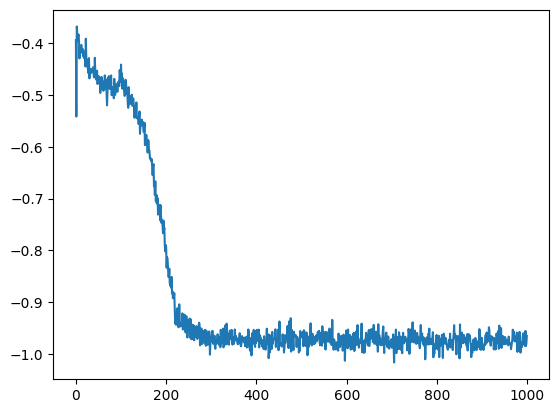

In [7]:
plt.plot(record_history.energies)

In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile

from qiskit_aer import QasmSimulator, AerSimulator
# from qiskit_aer.noise import NoiseModel, pauli_error

from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import Aer, execute

from scipy.optimize import OptimizeResult

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print('eps', eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion
    # backend = QasmSimulator(method='statevector', noise_model=noise_model)
    backend = QasmSimulator()
    # backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots



    # job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    transpiled_circuit = transpile(circ, backend)
    job = backend.run(circ, shots=shots1)
    # job = execute(circ, backend, shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    # transpiled_circuit = transpile(circ_2, backend)
    job = backend.run(circ_2, shots=shots2)
    # job = execute(circ_2, backend, shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    transpiled_circuit = transpile(circ_3, backend)
    job = backend.run(circ_3, shots=shots2)
    # job = execute(circ_3, backend, shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])
    print("Len: ", len(history.energies))

    return E


theta_test = [-2]
shots = 600

record_history = history()
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(args.shots, args.trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.3771860058
Len:  1
theta track:  [-1]
energy track:  -0.5502910058
Len:  2
eps 0.02
theta track:  [-1.9]
energy track:  -0.3762830057999999
Len:  3
theta track:  [-1.88]
energy track:  -0.3975390058
Len:  4
eps 0.02
theta track:  [-1.82377451]
energy track:  -0.3876400058
Len:  5
theta track:  [-1.80377451]
energy track:  -0.39140900579999993
Len:  6
eps 0.02
theta track:  [-1.76337711]
energy track:  -0.4128970058000001
Len:  7
theta track:  [-1.74337711]
energy track:  -0.41400700580000005
Len:  8
eps 0.02
theta track:  [-1.71350676]
energy track:  -0.43415300580000005
Len:  9
theta track:  [-1.69350676]
energy track:  -0.40565700579999997
Len:  10
eps 0.02
theta track:  [-1.68149988]
energy track:  -0.4067670058
Len:  11
theta track:  [-1.66149988]
energy track:  -0.41867900580000006
Len:  12
eps 0.02
theta track:  [-1.65019762]
energy track:  -0.3996430057999999
Len:  13
theta track:  [-1.63019762]
energy track:  -0.4215700058
Len:  14
eps 0.02


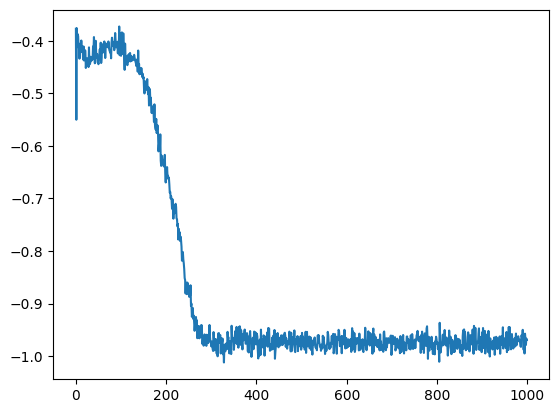

In [18]:
plt.plot(record_history.energies)

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile

from qiskit_aer import QasmSimulator, AerSimulator
# from qiskit_aer.noise import NoiseModel, pauli_error

from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import Aer, execute

from scipy.optimize import OptimizeResult

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print('eps', eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion
    # backend = QasmSimulator(method='statevector', noise_model=noise_model)
    # backend = QasmSimulator()
    backend = QasmSimulator(noise_model=noise_model)
    # backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots



    # job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    transpiled_circuit = transpile(circ, backend)
    job = backend.run(circ, shots=shots1)
    # job = execute(circ, backend, shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    # transpiled_circuit = transpile(circ_2, backend)
    job = backend.run(circ_2, shots=shots2)
    # job = execute(circ_2, backend, shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    transpiled_circuit = transpile(circ_3, backend)
    job = backend.run(circ_3, shots=shots2)
    # job = execute(circ_3, backend, shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])
    print("Len: ", len(history.energies))

    return E


theta_test = [-2]
shots = 600

record_history = history()
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(args.shots, args.trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.2674380058
Len:  1
theta track:  [-1]
energy track:  -0.3559770058
Len:  2
eps 0.02
theta track:  [-1.9]
energy track:  -0.2686760058
Len:  3
theta track:  [-1.88]
energy track:  -0.2768300058
Len:  4
eps 0.02
theta track:  [-1.82579136]
energy track:  -0.23814000579999994
Len:  5
theta track:  [-1.80579136]
energy track:  -0.22679600579999998
Len:  6
eps 0.02
theta track:  [-1.77792474]
energy track:  -0.2306690058
Len:  7
theta track:  [-1.75792474]
energy track:  -0.2840500058
Len:  8
eps 0.02
theta track:  [-1.71322583]
energy track:  -0.2772790058
Len:  9
theta track:  [-1.69322583]
energy track:  -0.22613200579999998
Len:  10
eps 0.02
theta track:  [-1.69028419]
energy track:  -0.25239500579999996
Len:  11
theta track:  [-1.67028419]
energy track:  -0.2380380058
Len:  12
eps 0.02
theta track:  [-1.67745832]
energy track:  -0.27642900579999996
Len:  13
theta track:  [-1.65745832]
energy track:  -0.2991620058
Len:  14
eps 0.02
theta track:  [-1.

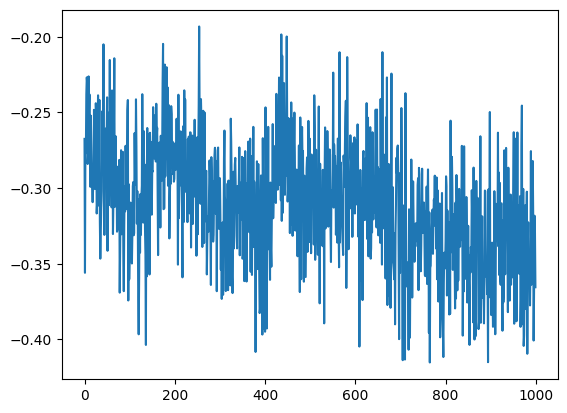

In [21]:
plt.plot(record_history.energies)

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile

from qiskit_aer import QasmSimulator, AerSimulator
# from qiskit_aer.noise import NoiseModel, pauli_error

from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import Aer, execute

from scipy.optimize import OptimizeResult

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print('eps', eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion
    # backend = QasmSimulator(method='statevector', noise_model=noise_model)
    # backend = AerSimulator()
    backend = QasmSimulator()
    # backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots



    # job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    transpiled_circuit = transpile(circ, backend)
    job = backend.run(circ, shots=shots1)
    # job = execute(circ, backend, shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    # transpiled_circuit = transpile(circ_2, backend)
    job = backend.run(circ_2, shots=shots2)
    # job = execute(circ_2, backend, shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    transpiled_circuit = transpile(circ_3, backend)
    job = backend.run(circ_3, shots=shots2)
    # job = execute(circ_3, backend, shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])
    print("Len: ", len(history.energies))

    return E


theta_test = [-2]
shots = 600

record_history = history()
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(args.shots, args.trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.38153500579999994
Len:  1
theta track:  [-1]
energy track:  -0.5330360058
Len:  2
eps 0.02
theta track:  [-1.9]
energy track:  -0.3835230058
Len:  3
theta track:  [-1.88]
energy track:  -0.3796130057999999
Len:  4
eps 0.02
theta track:  [-1.83509946]
energy track:  -0.3855110058
Len:  5
theta track:  [-1.81509946]
energy track:  -0.38918900580000004
Len:  6
eps 0.02
theta track:  [-1.78327132]
energy track:  -0.39908800580000003
Len:  7
theta track:  [-1.76327132]
energy track:  -0.3842850058
Len:  8
eps 0.02
theta track:  [-1.74716928]
energy track:  -0.38662100580000003
Len:  9
theta track:  [-1.72716928]
energy track:  -0.38606600580000006
Len:  10
eps 0.02
theta track:  [-1.71687246]
energy track:  -0.4026500058
Len:  11
theta track:  [-1.69687246]
energy track:  -0.39663600579999997
Len:  12
eps 0.02
theta track:  [-1.69301845]
energy track:  -0.42457700579999996
Len:  13
theta track:  [-1.67301845]
energy track:  -0.39552600579999997
Len:  14


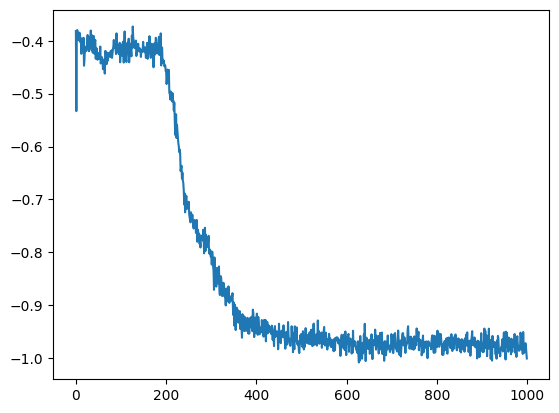

In [10]:
plt.plot(record_history.energies)

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile

from qiskit_aer import QasmSimulator, AerSimulator
# from qiskit_aer.noise import NoiseModel, pauli_error

from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import Aer, execute

from scipy.optimize import OptimizeResult

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print('eps', eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion
    backend = QasmSimulator(noise_model=noise_model)
    # backend = AerSimulator()
    # backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots



    # job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    transpiled_circuit = transpile(circ, backend)
    job = backend.run(circ, shots=shots1)
    # job = execute(circ, backend, shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    # transpiled_circuit = transpile(circ_2, backend)
    job = backend.run(circ_2, shots=shots2)
    # job = execute(circ_2, backend, shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    transpiled_circuit = transpile(circ_3, backend)
    job = backend.run(circ_3, shots=shots2)
    # job = execute(circ_3, backend, shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])
    print("Len: ", len(history.energies))

    return E


theta_test = [-2]
shots = 600

record_history = history()
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(args.shots, args.trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.2805190058
Len:  1
theta track:  [-1]
energy track:  -0.30141700579999997
Len:  2
eps 0.02
theta track:  [-1.9]
energy track:  -0.2097140058
Len:  3
theta track:  [-1.88]
energy track:  -0.22675100580000002
Len:  4
eps 0.02
theta track:  [-1.80073523]
energy track:  -0.2837260058
Len:  5
theta track:  [-1.78073523]
energy track:  -0.26359700579999995
Len:  6
eps 0.02
theta track:  [-1.77871366]
energy track:  -0.2824560057999999
Len:  7
theta track:  [-1.75871366]
energy track:  -0.2172450058
Len:  8
eps 0.02
theta track:  [-1.82238285]
energy track:  -0.2546390058
Len:  9
theta track:  [-1.80238285]
energy track:  -0.2363410058
Len:  10
eps 0.02
theta track:  [-1.87143286]
energy track:  -0.2781910058
Len:  11
theta track:  [-1.85143286]
energy track:  -0.25031400579999996
Len:  12
eps 0.02
theta track:  [-1.92919768]
energy track:  -0.22647800580000002
Len:  13
theta track:  [-1.90919768]
energy track:  -0.23399000579999998
Len:  14
eps 0.02
theta

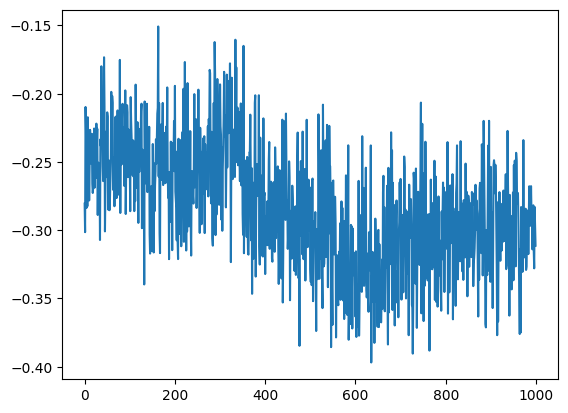

In [14]:
plt.plot(record_history.energies)

In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile

from qiskit_aer import QasmSimulator, AerSimulator
# from qiskit_aer.noise import NoiseModel, pauli_error

from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import Aer, execute

from scipy.optimize import OptimizeResult

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print('eps', eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion
    # backend = QasmSimulator(noise_model=noise_model)
    backend = AerSimulator(noise_model=noise_model)
    # backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots



    # job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    transpiled_circuit = transpile(circ, backend)
    job = backend.run(circ, shots=shots1)
    # job = execute(circ, backend, shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    # transpiled_circuit = transpile(circ_2, backend)
    job = backend.run(circ_2, shots=shots2)
    # job = execute(circ_2, backend, shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    transpiled_circuit = transpile(circ_3, backend)
    job = backend.run(circ_3, shots=shots2)
    # job = execute(circ_3, backend, shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])
    print("Len: ", len(history.energies))

    return E


theta_test = [-2]
shots = 600

record_history = history()
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(args.shots, args.trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.18679200580000002
Len:  1
theta track:  [-1]
energy track:  -0.28288900580000004
Len:  2
eps 0.02
theta track:  [-1.9]
energy track:  -0.2760790058
Len:  3
theta track:  [-1.88]
energy track:  -0.2234280058
Len:  4
eps 0.02
theta track:  [-1.88496084]
energy track:  -0.2791180058
Len:  5
theta track:  [-1.86496084]
energy track:  -0.3205190058
Len:  6
eps 0.02
theta track:  [-1.8489263]
energy track:  -0.3016520058
Len:  7
theta track:  [-1.8289263]
energy track:  -0.22913900579999996
Len:  8
eps 0.02
theta track:  [-1.85788777]
energy track:  -0.2918790058
Len:  9
theta track:  [-1.83788777]
energy track:  -0.2589180058
Len:  10
eps 0.02
theta track:  [-1.87893053]
energy track:  -0.2481360058
Len:  11
theta track:  [-1.85893053]
energy track:  -0.2385410058
Len:  12
eps 0.02
theta track:  [-1.90082859]
energy track:  -0.22816500580000001
Len:  13
theta track:  [-1.88082859]
energy track:  -0.24498100580000004
Len:  14
eps 0.02
theta track:  [-1.91

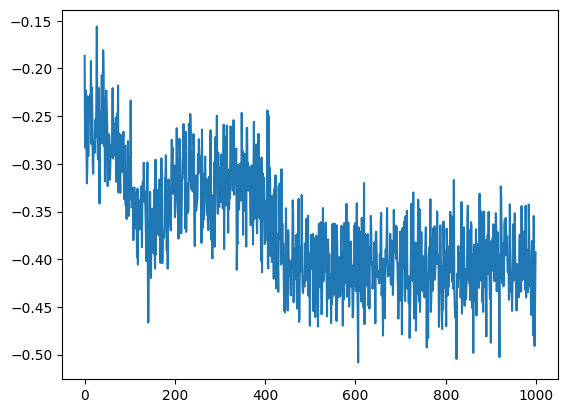

In [16]:
plt.plot(record_history.energies)

#### Legacy Method

In [24]:

p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
p_phase = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_phase = pauli_error([('Z',p_phase), ('I', 1 - p_phase)])

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1.compose(error_phase), ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2.compose(error_phase.tensor(error_phase)), ["cx"])


# Here, we use parameters given for H2 at R=1.75A
g0 = -0.5597
g1 = +0.1615
g2 = -0.0166
g3 = +0.4148
g4 = +0.1226
g5 = +0.1226

nuclear_repulsion = 0.3023869942
Energy_FCI = -0.97516853

def func_and_gradient(x_opt, fun, eps):
    f = fun(x_opt)
    grad = np.zeros_like(x_opt)

    for i in range(x_opt.size):
        x_plus_h = x_opt.copy()
        x_plus_h[i] += eps
        f_plus_h = fun(x_plus_h)
        # print(f_plus_h, f)
        grad[i] = (f_plus_h - f) / eps
    print('eps', eps)
    return f, grad


def adam(fun, x0, jac=None, iters=100, options=None, beta1=0.9, beta2=0.999, epsilon=1e-8, eps=0.02):
    # learning rate
    base_lr = 0.1

    # Initialize the ADAM variables
    t = 0
    m_t = 0
    v_t = 0

    # Initialize the optimization result
    nit = 0
    nfev = 0
    njev = 0
    success = False
    message = ''
    fun_val = np.inf
    x_opt = np.copy(x0)

    if options is None:
        options = {}
    maxiter = options.get('maxiter', iters)

    while nit < maxiter:
        # Compute the function value and gradient
        fval, grad = func_and_gradient(x_opt, fun, eps)  # approx_fprime(x_opt, fun, eps)
        nfev += 2
        njev += 1

        fun_val = fval
        # Compute the ADAM update
        t += 1
        m_t = beta1 * m_t + (1 - beta1) * grad
        v_t = beta2 * v_t + (1 - beta2) * grad ** 2
        m_t_hat = m_t / (1 - beta1 ** t)
        v_t_hat = v_t / (1 - beta2 ** t)

        lr_current = 0.5 * base_lr * (math.cos(math.pi * nit / maxiter) + 1)
        lr = lr_current / (np.sqrt(v_t_hat) + epsilon)

        # Update the parameters
        x_opt = x_opt - lr * m_t_hat

        nit += 1

    result = OptimizeResult(fun=fun_val, x=x_opt, nit=nit, nfev=nfev, njev=njev, success=success, message=message)

    return result

def get_probability_distribution_2(counts, NUM_SHOTS):

    for k in {'00', '01', '10', '11'}:
        if k not in counts.keys():
            counts[k] = 0
    sorted_counts = sorted(counts.items())

    output_distr = [ v[1] / NUM_SHOTS for v in sorted_counts]
    if len(output_distr) == 1:
        output_distr.append(1-output_distr[0])
    return output_distr

class history:
    def __init__(self):
        self.thetas = []
        self.energies = []
        self.P1 = []
        self.P2 = []
        self.P3 = []


def simulator(theta, shots, history):
    E = g0 + nuclear_repulsion
    # backend = QasmSimulator(method='statevector', noise_model=noise_model)
    backend = Aer.get_backend('qasm_simulator', noise_model=noise_model)

    # Get the expectation value of the first three terms <Z0>, <Z1>, <Z0Z1>
    circ = QuantumCircuit(2,2)
    circ.name = "H2 STO-3G g1-g3"
    circ.x(0)
    circ.ry(np.pi/2,1)
    circ.rx(3*np.pi/2,0)
    circ.cx(1,0)
    circ.rz(theta[0],0)
    circ.cx(1,0)
    circ.ry(3*np.pi/2,1)
    circ.rx(np.pi/2,0)
    circ.measure([0,1], [0,1])

    # Get the expectation value of <Y0Y1>
    circ_2 = QuantumCircuit(2,2)
    circ_2.name = "H2 STO-3G g4"
    circ_2.x(0)
    circ_2.ry(np.pi/2,1)
    circ_2.rx(3*np.pi/2,0)
    circ_2.cx(1,0)
    circ_2.rz(theta[0],0)
    circ_2.cx(1,0)
    circ_2.ry(3*np.pi/2,1)
    circ_2.rx(np.pi/2,0)
    circ_2.sdg(1)
    circ_2.h(1)
    circ_2.sdg(0)
    circ_2.h(0)
    circ_2.measure([0,1], [0,1])

    # Get the expectation value of <X0X1>
    circ_3 = QuantumCircuit(2,2)
    circ_3.name = "H2 STO-3G g5"
    circ_3.x(0)
    circ_3.ry(np.pi/2,1)
    circ_3.rx(3*np.pi/2,0)
    circ_3.cx(1,0)
    circ_3.rz(theta[0],0)
    circ_3.cx(1,0)
    circ_3.ry(3*np.pi/2,1)
    circ_3.rx(np.pi/2,0)
    circ_3.h(1)
    circ_3.h(0)
    circ_3.measure([0,1], [0,1])

    shots1, shots2, shots3 = shots



    # job = execute(circ, Aer.get_backend('qasm_simulator', noise_model=noise_model), shots=shots1)
    transpiled_circuit = transpile(circ, backend)
    # job = backend.run(transpiled_circuit, shots=shots1)
    job = execute(circ, Aer.get_backend('qasm_simulator'), shots=shots1)
    result = job.result()

    counts = result.get_counts(circ)
    output_distr = get_probability_distribution_2(counts, shots1)
    history.P1.append(output_distr)

    E1 = -g1 * (output_distr[0] + output_distr[1] - output_distr[2] - output_distr[3])
    E2 = -g2 * (output_distr[0] - output_distr[1] + output_distr[2] - output_distr[3])
    E3 = g3 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    E += E1 + E2 + E3

    transpiled_circuit = transpile(circ_2, backend)
    # job = backend.run(transpiled_circuit, shots=shots2)
    job = execute(circ_2, Aer.get_backend('qasm_simulator'), shots=shots2)
    result = job.result()
    counts = result.get_counts(circ_2)
    output_distr = get_probability_distribution_2(counts, shots2)
    E += g4 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P2.append(output_distr)

    transpiled_circuit = transpile(circ_3, backend)
    # job = backend.run(transpiled_circuit, shots=shots2)
    job = execute(circ_3, Aer.get_backend('qasm_simulator'), shots=shots3)
    result = job.result()
    counts = result.get_counts(circ_3)
    output_distr = get_probability_distribution_2(counts, shots3)
    E += g5 * (output_distr[0] - output_distr[1] - output_distr[2] + output_distr[3])
    history.P3.append(output_distr)

    history.thetas.append(theta)
    history.energies.append(E)

    print('theta track: ', history.thetas[-1])
    print('energy track: ', history.energies[-1])
    print("Len: ", len(history.energies))

    return E


theta_test = [-2]
shots = 600

record_history = history()
per_shots = shots//3

# ADAM optimizer
result = adam(lambda x: simulator(x, shots=(per_shots,per_shots,per_shots), history=record_history), theta_test, iters=500, eps=0.02)

# np.savez('qiskit_adam1d_zero_initialization/Equal-noisyvqe_adam_shots{}_init_-2-eps0p02-iter500-coslr-trial{}.npz'.format(args.shots, args.trial),
#     theta=record_history.thetas, energy=record_history.energies, P1=record_history.P1, P2=record_history.P2, P3=record_history.P3)

theta track:  [-2]
energy track:  -0.36483500579999995
Len:  1
theta track:  [-1]
energy track:  -0.5694430058000002
Len:  2
eps 0.02
theta track:  [-1.9]
energy track:  -0.39943600579999994
Len:  3
theta track:  [-1.88]
energy track:  -0.37383100579999995
Len:  4
eps 0.02
theta track:  [-1.84299208]
energy track:  -0.3756120057999999
Len:  5
theta track:  [-1.82299208]
energy track:  -0.38384600579999995
Len:  6
eps 0.02
theta track:  [-1.79635385]
energy track:  -0.4104450058000001
Len:  7
theta track:  [-1.77635385]
energy track:  -0.4004300058
Len:  8
eps 0.02
theta track:  [-1.76108416]
energy track:  -0.38840200579999984
Len:  9
theta track:  [-1.74108416]
energy track:  -0.39853300580000006
Len:  10
eps 0.02
theta track:  [-1.72857612]
energy track:  -0.4200210057999999
Len:  11
theta track:  [-1.70857612]
energy track:  -0.3919640058
Len:  12
eps 0.02
theta track:  [-1.70801603]
energy track:  -0.40197900579999996
Len:  13
theta track:  [-1.68801603]
energy track:  -0.430475005

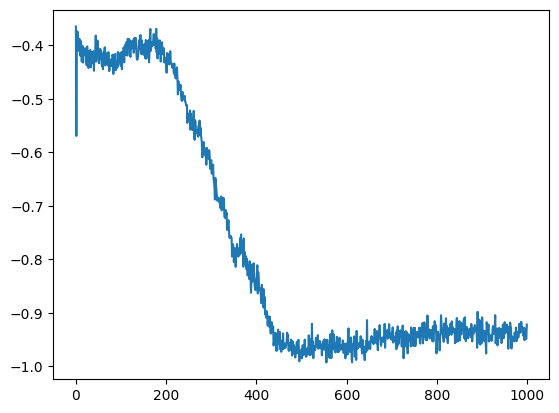

In [25]:
plt.plot(record_history.energies)